<a href="https://colab.research.google.com/github/mkrsteska/BSA2020_Team_Tissot_Project_2/blob/master/fake_real_news_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd

I tried using a different data set of fake&real news to see if a model trained on that could be used on the twitter database

**It does not work :(**

In [0]:
real_news = pd.read_csv("https://raw.githubusercontent.com/mkrsteska/BSA2020_Team_Tissot_Project_2/master/data/real_news.csv",
                        sep =';',
                        encoding='utf_8', 
                        dtype = 'unicode',
                        low_memory= False)

fake_news = pd.read_csv("https://raw.githubusercontent.com/mkrsteska/BSA2020_Team_Tissot_Project_2/master/data/fake_news.csv", 
                        sep =';',
                        encoding='utf_8', 
                        dtype = 'unicode',
                        low_memory= False)

In [0]:
df_train = pd.read_csv("https://raw.githubusercontent.com/DLaux/BSA2020_Team_Tissot_Project_2/master/data/train.csv", 
                          encoding='utf_8', 
                          dtype = 'unicode',
                          parse_dates = True,
                          infer_datetime_format = True,
                          low_memory=False)

df_test = pd.read_csv("https://raw.githubusercontent.com/DLaux/BSA2020_Team_Tissot_Project_2/master/data/test.csv", 
                          encoding='utf_8', 
                          dtype = 'unicode',
                          parse_dates = True,
                          infer_datetime_format = True,
                          low_memory=False)

In [0]:
fake_news['target'] = 0
real_news['target'] = 1
news = pd.concat([fake_news, real_news]).reset_index(drop = True)

news = news.drop(["label"], axis = 1)


In [5]:
news.head()

,id,title,text,target
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
3,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",0
4,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",0


In [6]:
news.groupby(["target"]).count()

,id,title,text
target,,,
0,3165,3165,3164
1,3215,3179,3167


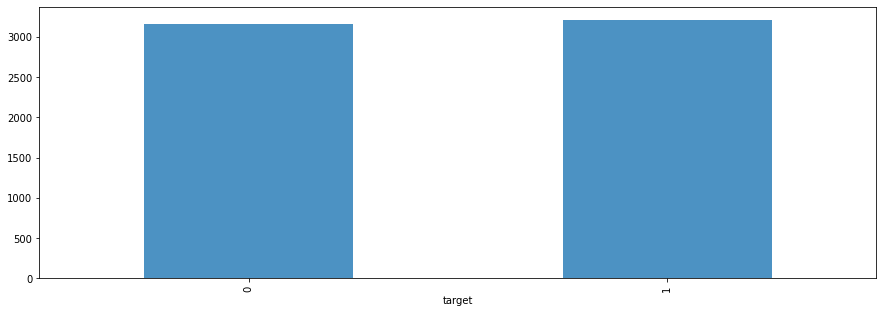

In [7]:
r1 = news[["id","target"]].groupby(["target"]).count()
r1.plot.bar(x=None, 
            y=None,
            figsize=(15,5), 
            alpha = 0.8, # make the plot 20% transparent
            legend = None, 
           )

## Preprocessing data

In [0]:
from sklearn import preprocessing
from sklearn import utils
from sklearn.model_selection import train_test_split

In [0]:
X = news['text'].astype('str')
y = news["target"].astype('str')

In [0]:
#encode the target 
lab_enc = preprocessing.LabelEncoder()
encoded_y = lab_enc.fit_transform(y)

In [0]:
# split train/test
#X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size=0.2, random_state=72, stratify=encoded_y)

X_train = X
y_train = encoded_y

Now we will split the train data from Kaggle that we will use as test

In [0]:
#encode the target 
lab_enc = preprocessing.LabelEncoder()
encoded_y_test = lab_enc.fit_transform(df_train['target'].astype('str'))

In [0]:
X_test = df_train['text'].astype("str")
y_test = encoded_y_test

In [63]:
print(len(X_test))
print(len(y_test))

7613
7613


### Text processing

In [23]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
import string
import re
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

In [0]:
X_train = X_train.apply(lambda x: remove_punct(x))

In [0]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [0]:
X_train = X_train.apply(lambda x: remove_URL(x))

Tokenization

In [82]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(min_df=2, max_df=0.75, encoding='utf-8')
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(6416, 41584)

Bag of words

In [83]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(6416, 41584)

This is just to test how effectif these methods are for our data set, later on we will do every step in a pipeline

In [84]:
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer(min_df=3, max_df=0.75, encoding='utf-8')),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier())])

model = pipe.fit(X_train, y_train)
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.57      1.00      0.73      4342
           1       0.17      0.00      0.00      3271

    accuracy                           0.57      7613
   macro avg       0.37      0.50      0.36      7613
weighted avg       0.40      0.57      0.41      7613

[[4337    5]
 [3270    1]]


## Selecting a model

In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

classifiers = [   
    KNeighborsClassifier(n_neighbors = 10,weights = 'distance',algorithm = 'brute'),
    SVC(kernel="rbf", C=0.025, probability=True, random_state=42),
    NuSVC(probability=True, random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    MultinomialNB(),
    SGDClassifier(random_state=42)
    ]

for classifier in classifiers:
    pipe = Pipeline([
                     ('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     #('smote', SMOTE()),
                     ('classifier', classifier)
                     ])
    pipe.fit(X_train, y_train)   
    print(classifier)
    print("model score: %.3f" % pipe.score(X_test, y_test))
    
    predictions = pipe.predict(X_test)
    print(classification_report(y_test, predictions))
    print(confusion_matrix(y_test, predictions))

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')
model score: 0.570


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.57      1.00      0.73      4342
           1       0.00      0.00      0.00      3271

    accuracy                           0.57      7613
   macro avg       0.29      0.50      0.36      7613
weighted avg       0.33      0.57      0.41      7613

[[4342    0]
 [3271    0]]
